In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.integrate import quad

In [2]:
def signal(S0, t, tau):
    return S0 / np.sqrt(1 + np.cosh(t/tau)**2)

In [3]:
def periodic_signal(S0, t, tau, period):
    t_mod = np.mod(t + period/2, period) - period/2
    return signal(S0, t_mod, tau)

In [4]:
S0 = 1.0
taus = [0.15, 0.285]
T = 4.0
f0 = 1/T

t = np.linspace(-2, 2, 1000)
periodic_t = np.linspace(0, 10, 1000)

signals = [signal(S0, t, tau) for tau in taus]
periodic_signals = [periodic_signal(S0, periodic_t, tau, T) for tau in taus]

colors = ['red', 'blue']


In [5]:
def plot_signal(t, signals, colors, taus):
    plt.figure(figsize=(10, 6))

    for i in range(len(signals)):
        plt.plot(t, signals[i], label=f'τ = {taus[i]}', color=colors[i])

    plt.title('$S(t) = S_0 / \sqrt{1 + \cosh^2(t/τ)}$')
    plt.xlabel('Time t')
    plt.ylabel('Amplitude S(t)')
    plt.legend()
    plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1751818/2730809149.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$S(t) = S_0 / \sqrt{1 + \cosh^2(t/τ)}$')


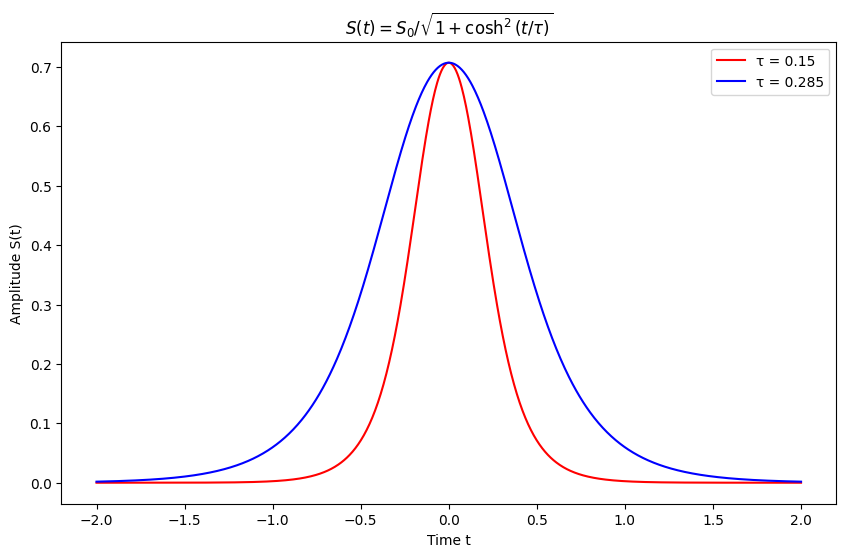

In [6]:
plot_signal(t, signals=signals, colors=colors, taus=taus)

In [7]:
def compute_discrete_spectrum(signal, N, T):
    yf = fft(signal)
    freq = fftfreq(N, T/N)
    amplitudes = np.abs(yf) / N * 2
    return freq[:N//2], amplitudes[:N//2]

In [8]:
def find_harmonics(frequencies, amplitudes, f0, tolerance=0.1):
    harmonics = []
    harmonic_amps = []
    
    for n in range(0, 41):
        target_freq = n * f0
        idx = np.argmin(np.abs(frequencies - target_freq))

        if np.abs(frequencies[idx] - target_freq) < tolerance:
            harmonics.append(frequencies[idx])
            harmonic_amps.append(amplitudes[idx])
    
    return harmonics, harmonic_amps

In [9]:
freq1, amp1 = compute_discrete_spectrum(periodic_signals[0], len(periodic_t), T)
freq2, amp2 = compute_discrete_spectrum(periodic_signals[1], len(periodic_t), T)

harmonics1, amps1 = find_harmonics(freq1, amp1, f0)
harmonics2, amps2 = find_harmonics(freq2, amp2, f0)

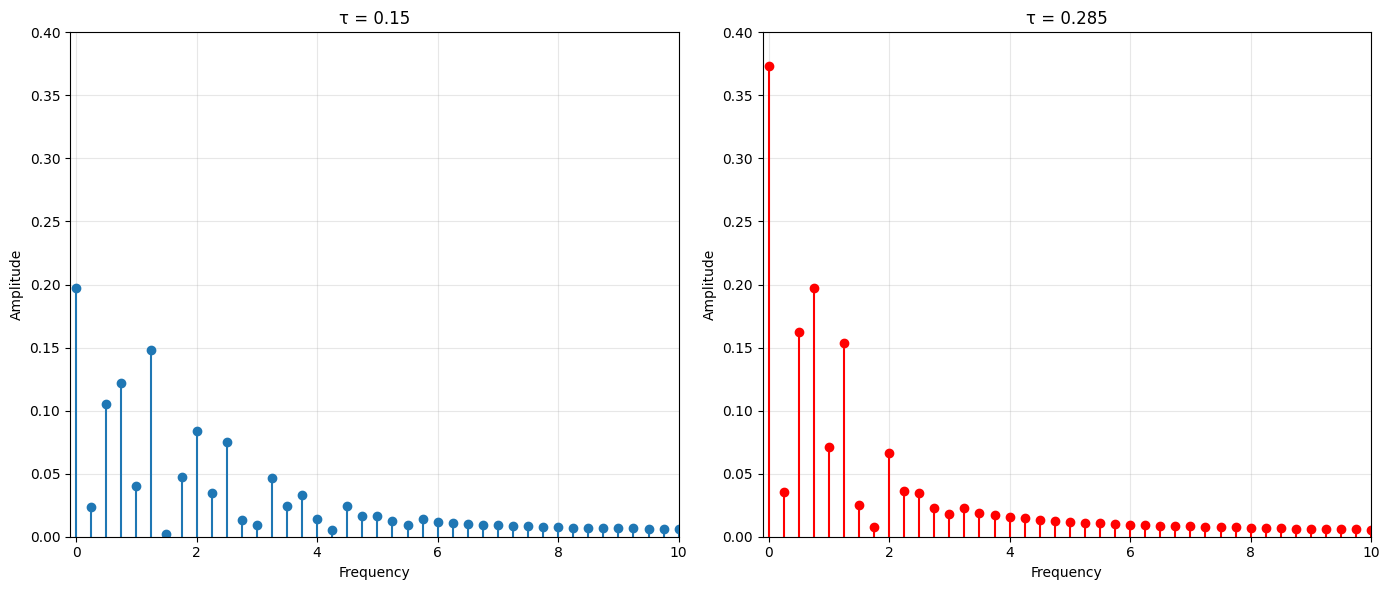

In [10]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.stem(harmonics1, amps1, basefmt=" ")
plt.title(f'τ = {taus[0]}')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.xlim(-0.1, 10)
plt.ylim(0, 0.4)

plt.subplot(1, 2, 2)
plt.stem(harmonics2, amps2, basefmt=" ", linefmt='r-', markerfmt='ro')
plt.title(f'τ = {taus[1]}')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.xlim(-0.1, 10)
plt.ylim(0, 0.4)

plt.tight_layout()
plt.show()

In [11]:
def estimate_bandwidth(harmonics, amplitudes, threshold):
    max_amplitude = max(amplitudes)
    
    last_significant_idx = -1
    
    for i, amp in enumerate(amplitudes):
        if amp > max_amplitude * threshold:
            last_significant_idx = i
    
    if last_significant_idx == -1:
        return 0, 0
    
    bandwidth = harmonics[last_significant_idx]
    
    return bandwidth

bw1 = estimate_bandwidth(harmonics1, amps1, threshold=0.05)
bw2 = estimate_bandwidth(harmonics2, amps2, threshold=0.05)

In [12]:
print(bw1)
print(bw2)

6.5
3.5


In [13]:
def fourier_coefficients(n_max, tau_val, period=T):
    a0 = (2/period) * quad(lambda t: signal(S0, t, tau_val), -period/2, period/2)[0]
    
    a_coeffs = np.zeros(n_max)
    b_coeffs = np.zeros(n_max)
    
    for n in range(1, n_max+1):
        omega_n = 2 * np.pi * n / period
        
        integrand_a = lambda t: signal(S0, t, tau_val) * np.cos(omega_n * t)
        a_coeffs[n-1] = (2/period) * quad(integrand_a, -period/2, period/2)[0]
        
        integrand_b = lambda t: signal(S0, t, tau_val) * np.sin(omega_n * t)
        b_coeffs[n-1] = (2/period) * quad(integrand_b, -period/2, period/2)[0]
    
    return a0, a_coeffs, b_coeffs

In [14]:
def fourier_series(t, a0, a_coeffs, b_coeffs, period=T):
    result = a0 / 2
    for n in range(1, len(a_coeffs)+1):
        omega_n = 2 * np.pi * n / period
        result += a_coeffs[n-1] * np.cos(omega_n * t) + b_coeffs[n-1] * np.sin(omega_n * t)
    return result

In [15]:
def calculate_error(a_coeffs, b_coeffs, n_used, period=T):
    total_power = 0
    for n in range(len(a_coeffs)):
        total_power += (a_coeffs[n]**2 + b_coeffs[n]**2) / 2
    
    discarded_power = 0
    for n in range(n_used, len(a_coeffs)):
        discarded_power += (a_coeffs[n]**2 + b_coeffs[n]**2) / 2
    
    relative_error = np.sqrt(discarded_power / total_power)
    return relative_error

In [16]:
def find_harmonics_for_error(tau_val, period=T, max_harmonics=100):
    a0, a_coeffs, b_coeffs = fourier_coefficients(max_harmonics, tau_val, period)
    
    n_for_error = {}
    
    for target_error in [0.1, 0.01]:
        for n in range(1, max_harmonics+1):
            error = calculate_error(a_coeffs, b_coeffs, n, period)
            if error <= target_error:
                n_for_error[target_error] = n
                break
    
    return a0, a_coeffs, b_coeffs, n_for_error

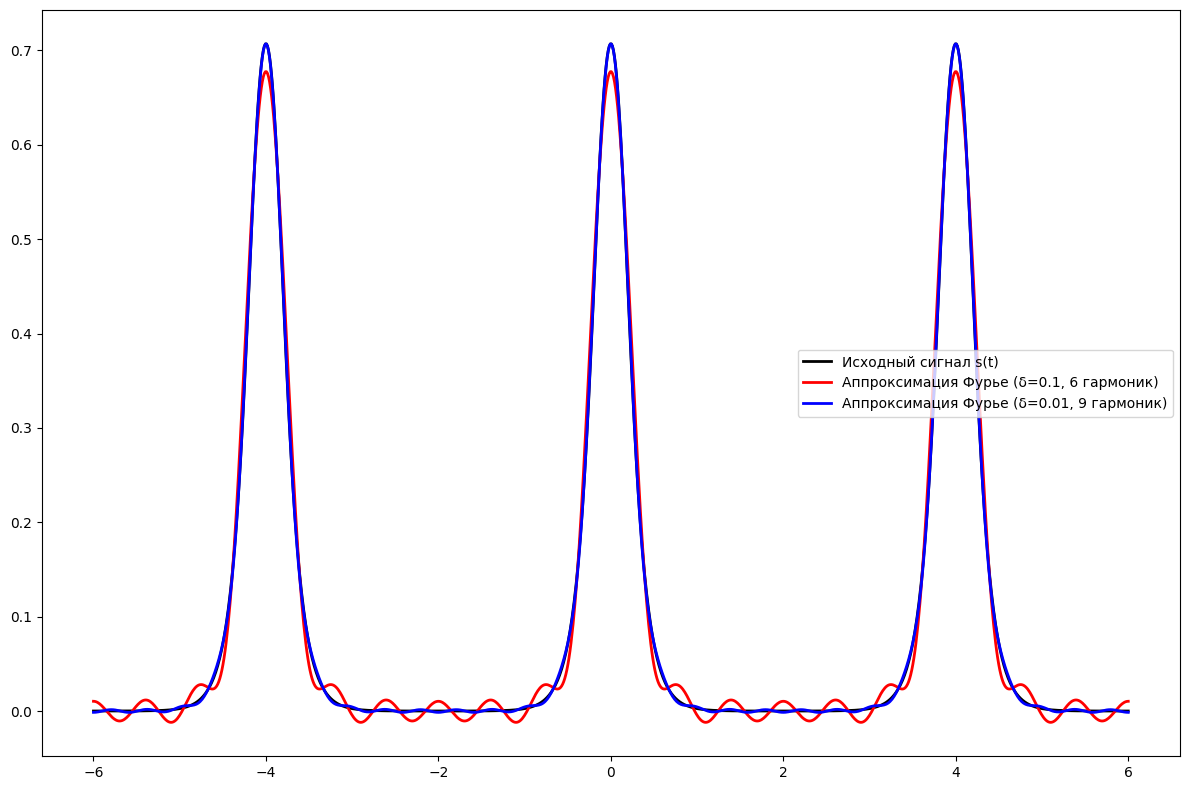

In [17]:
max_harmonics = 10
a0, a_coeffs, b_coeffs, n_for_error = find_harmonics_for_error(taus[0], T, max_harmonics)


t_values = np.linspace(-3*T/2, 3*T/2, 1000)

original_signal = [periodic_signal(S0,t, taus[0], T) for t in t_values]

fourier_approx_01 = [fourier_series(t, a0, a_coeffs[:n_for_error[0.1]], b_coeffs[:n_for_error[0.1]], T) for t in t_values]
fourier_approx_001 = [fourier_series(t, a0, a_coeffs[:n_for_error[0.01]], b_coeffs[:n_for_error[0.01]], T) for t in t_values]

plt.figure(figsize=(12, 8))

plt.plot(t_values, original_signal, 'k-', linewidth=2, label='Исходный сигнал s(t)')
plt.plot(t_values, fourier_approx_01, 'r', linewidth=2, label=f'Аппроксимация Фурье (δ=0.1, {n_for_error[0.1]} гармоник)')
plt.plot(t_values, fourier_approx_001, 'b', linewidth=2, label=f'Аппроксимация Фурье (δ=0.01, {n_for_error[0.01]} гармоник)')

plt.legend()

plt.tight_layout()
plt.show()

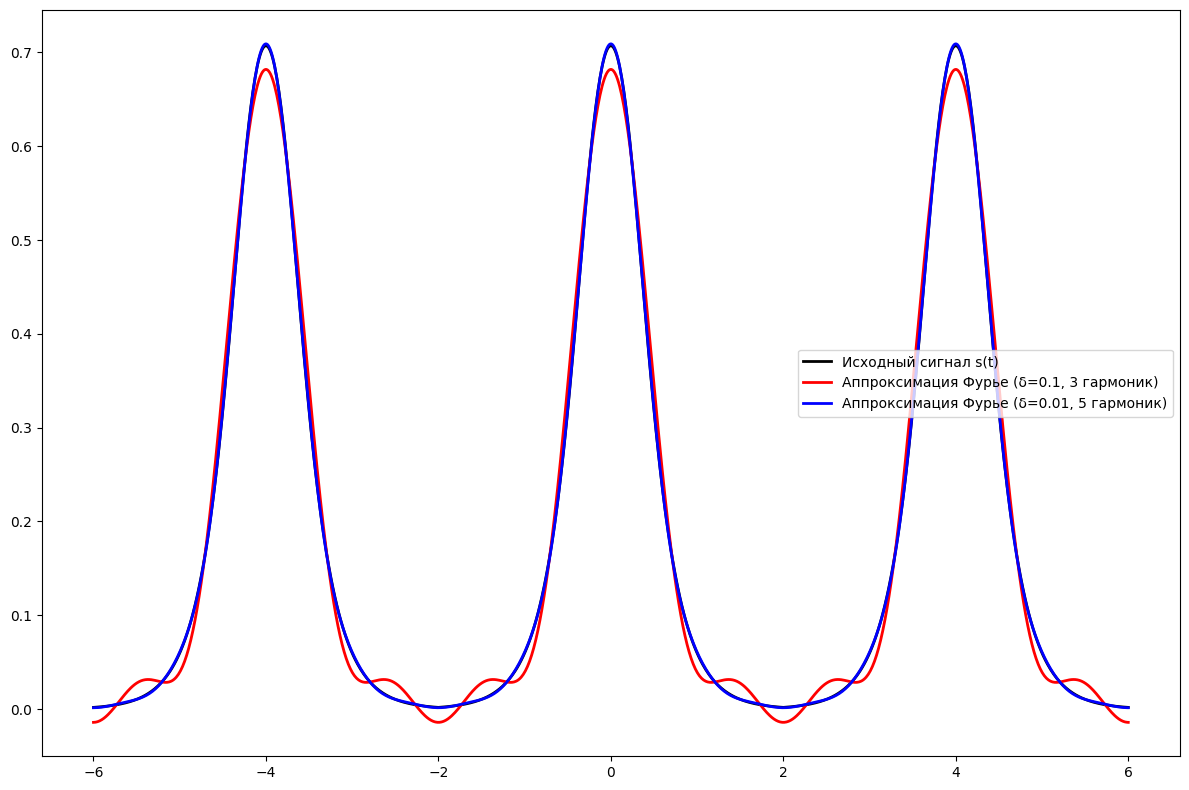

In [18]:
max_harmonics = 10
a0, a_coeffs, b_coeffs, n_for_error = find_harmonics_for_error(taus[1], T, max_harmonics)


t_values = np.linspace(-3*T/2, 3*T/2, 1000)

original_signal = [periodic_signal(S0,t, taus[1], T) for t in t_values]

fourier_approx_01 = [fourier_series(t, a0, a_coeffs[:n_for_error[0.1]], b_coeffs[:n_for_error[0.1]], T) for t in t_values]
fourier_approx_001 = [fourier_series(t, a0, a_coeffs[:n_for_error[0.01]], b_coeffs[:n_for_error[0.01]], T) for t in t_values]

plt.figure(figsize=(12, 8))

plt.plot(t_values, original_signal, 'k-', linewidth=2, label='Исходный сигнал s(t)')
plt.plot(t_values, fourier_approx_01, 'r', linewidth=2, label=f'Аппроксимация Фурье (δ=0.1, {n_for_error[0.1]} гармоник)')
plt.plot(t_values, fourier_approx_001, 'b', linewidth=2, label=f'Аппроксимация Фурье (δ=0.01, {n_for_error[0.01]} гармоник)')

plt.legend()

plt.tight_layout()
plt.show()